In [4]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import rcParams
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, spearmanr

#### Each row in the table contains a unique players post-game stats. The data comes from all types of games and there is no guarantee that each match will have the maximum of 100 players. The objective is to predict each players placement in a game by percentages, 1 being first place, 0 being last.

* groupId - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

* matchId - Integer ID to identify match. There are no matches that are in both the training and testing set.

* assists - Number of enemy players this player damaged that were killed by teammates.

* boosts - Number of boost items used.

* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

* DBNOs - Number of enemy players knocked.

* headshotKills - Number of enemy players killed with headshots.

* heals - Number of healing items used.

* killPlace - Ranking in match of number of enemy players killed.

* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)

* kills - Number of enemy players killed.

* killStreaks - Max number of enemy players killed in a short amount of time.

* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.

* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

* numGroups - Number of groups we have data for in the match.

* revives - Number of times this player revived teammates.

* rideDistance - Total distance traveled in vehicles measured in meters.

* roadKills - Number of kills while in a vehicle.

* swimDistance - Total distance traveled by swimming measured in meters.

* teamKills - Number of times this player killed a teammate.

* vehicleDestroys - Number of vehicles destroyed.

* walkDistance - Total distance traveled on foot measured in meters.

* weaponsAcquired - Number of weapons picked up.

* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)

* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [15]:
def load_data():
    gc.collect()
    train = pd.read_csv('./data/train.csv')
    analysis=train.sample(n=200000, random_state=42)
    del train

    return analysis

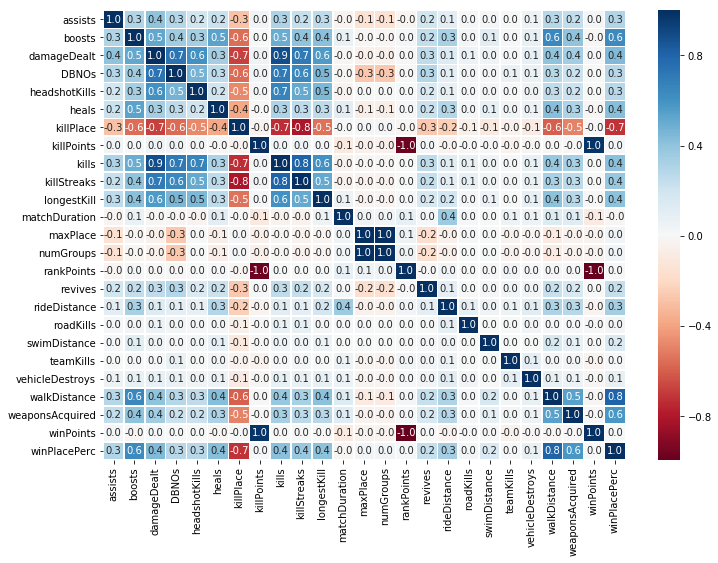

In [3]:


rcParams['figure.figsize'] = 11.7, 8.27

corr = analysis.corr()
sns.heatmap(
    corr,
    annot=True,
    linewidths=0.5,
    linecolor='white',
    fmt='.1f',
    cmap='RdBu',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)


We can see that the strongest correlation in the heat map is between killpoints and winpoints. That is to say, the more kill points you have the more often you win when winning is the only thing that matters.

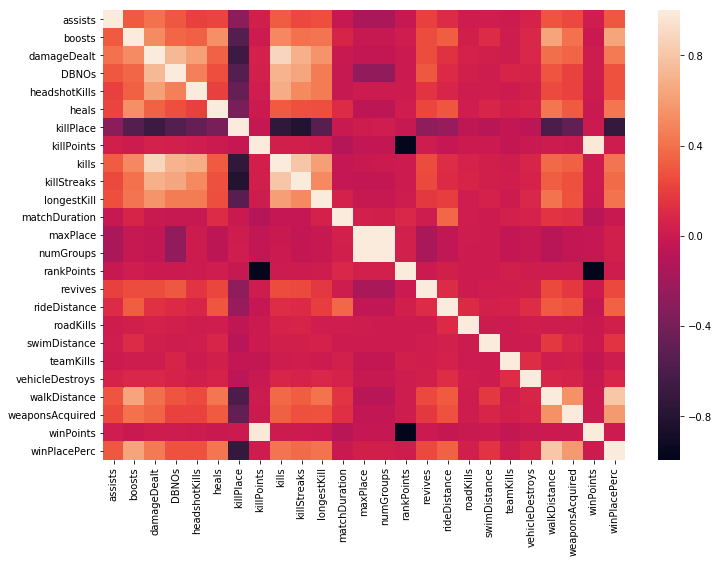

In [14]:
rcParams['figure.figsize'] = 11.7, 8.27

corr = train.corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)

The joinplot below has a top and side graph representing the marginals

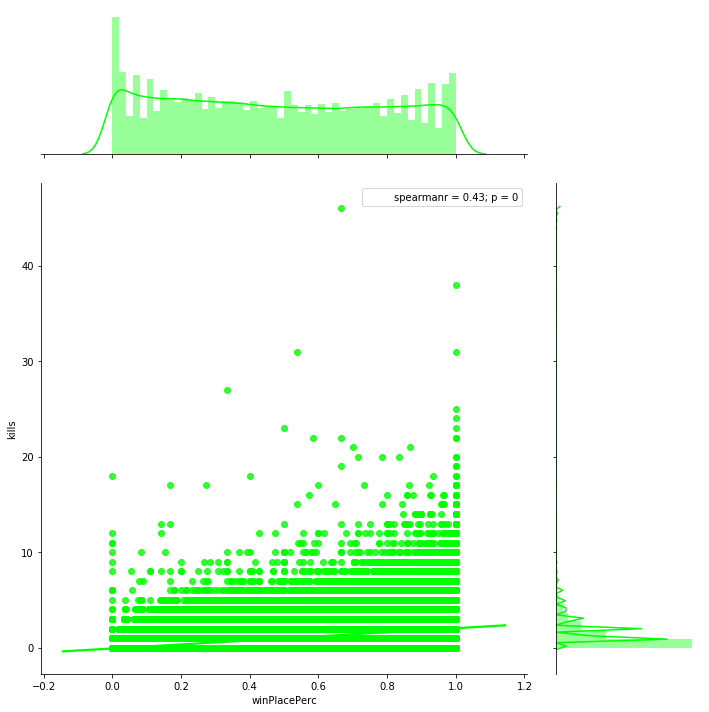

In [19]:
# Seeing if kills is directly correlated with WinPercentage

sns.jointplot(
    x="winPlacePerc", 
    y="kills", 
    data=analysis, 
    height=10, 
    ratio=3, 
    color='lime',
    kind='reg',
    stat_func=spearmanr)

plt.show()

(0, 15)

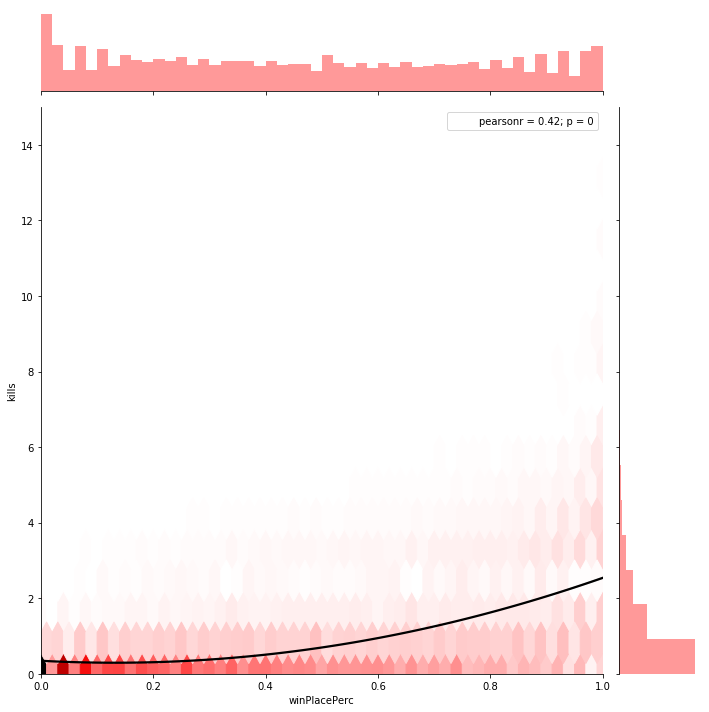

In [24]:
sns.jointplot(
    x="winPlacePerc", 
    y="kills", 
    data=analysis, 
    height=10, 
    ratio=6, 
    color='r',
    kind='hex',
    stat_func=pearsonr).plot_joint(sns.regplot, order=2, scatter=False, color='black')
plt.ylim(0, 15)

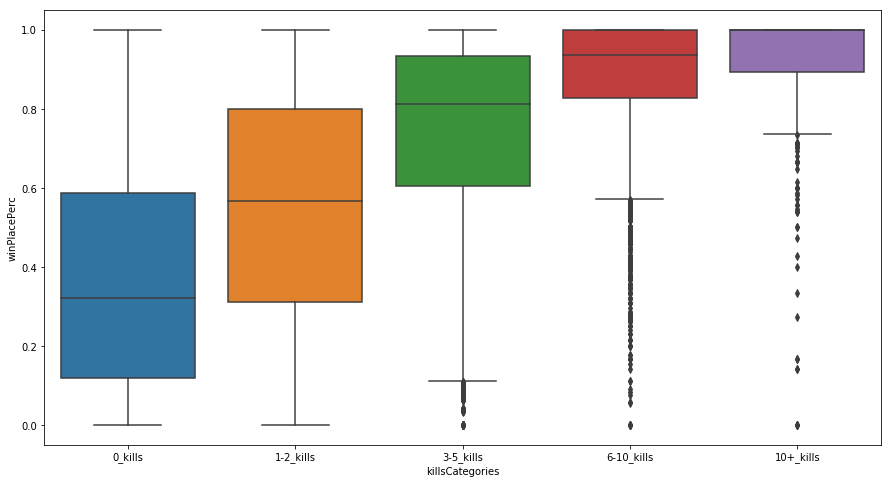

In [25]:
kills = analysis.copy()
plt.figure(figsize=(15,8))

kills['killsCategories'] = pd.cut(
    kills['kills'], 
    [-1, 0, 2, 5, 10, 60], 
    labels=['0_kills', '1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)

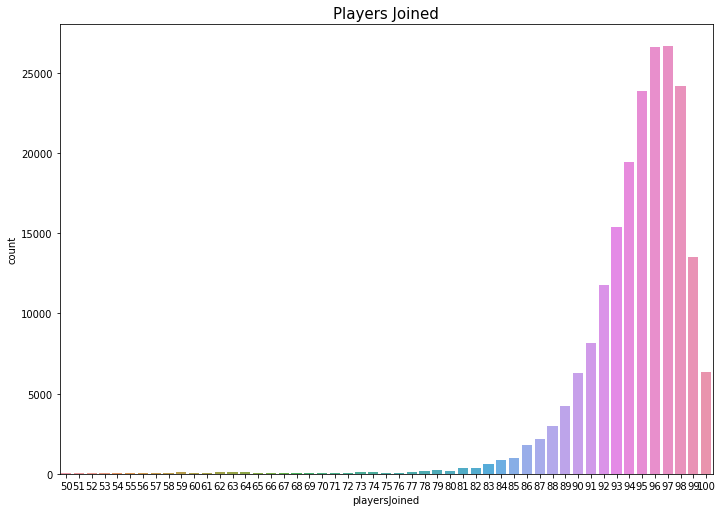

In [27]:
analysis['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

plot_data = analysis[analysis['playersJoined'] > 49]
sns.countplot(plot_data['playersJoined'])
plt.title("Players Joined", fontsize=15)
plt.show()

In [17]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

analysis = load_data()
analysis.drop(columns=['matchType'], inplace=True)




In [23]:
target = 'winPlacePerc'
drop_cols = ['Id', 'groupId', 'matchId', 'matchType', target]
fit_cols = [col for col in analysis if col not in drop_cols]

train, val = train_test_split(analysis, test_size=0.1, random_state=42)
params = {
    'n_estimators': 100,
    'learning_rate': 0.3,
    'num_leaves': 20,
    'objective': 'regression_l2',
    'metric': 'mae',
    'verbose': -1
}


model = LGBMRegressor(**params)
model.fit(
    train[fit_cols], train[target],
    eval_set=[(val[fit_cols], val[target])],
    eval_metric='mae',
    verbose=20)

[20]	valid_0's l1: 0.0651644
[40]	valid_0's l1: 0.0619168
[60]	valid_0's l1: 0.060701
[80]	valid_0's l1: 0.0602549
[100]	valid_0's l1: 0.0600278


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.3, max_depth=-1,
       metric='mae', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=20,
       objective='regression_l2', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbose=-1)

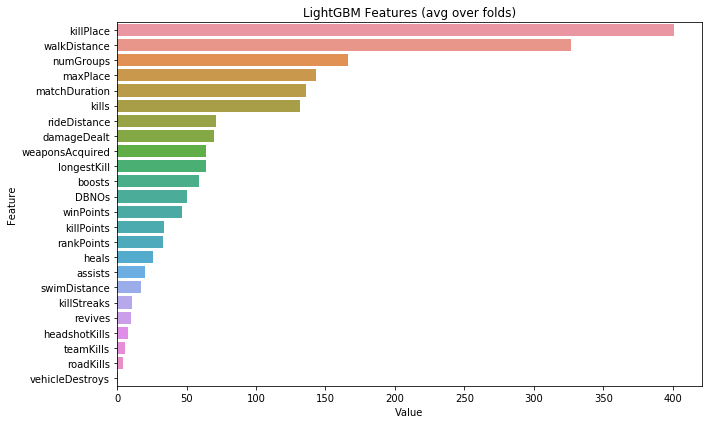

In [24]:
feature_importance = pd.DataFrame(
    sorted(zip(model.feature_importances_, fit_cols)),
    columns=['Value', 'Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Value',
    y='Feature',
    data=feature_importance.sort_values(by='Value', ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()


By using permutation importance we can determine how much a player's score decreases when a feature is not available as an input. This gives a measure of "Mean Decrease Accuracy"

In [26]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42) \
    .fit(val[fit_cols], val[target])
eli5.show_weights(perm, feature_names=list(fit_cols))

Weight,Feature
1.7726 ± 0.0109,killPlace
0.4380 ± 0.0080,kills
0.3206 ± 0.0035,walkDistance
0.1090 ± 0.0013,numGroups
0.0681 ± 0.0026,maxPlace
0.0287 ± 0.0016,matchDuration
0.0068 ± 0.0003,boosts
0.0059 ± 0.0003,rideDistance
0.0033 ± 0.0005,weaponsAcquired
0.0018 ± 0.0003,DBNOs


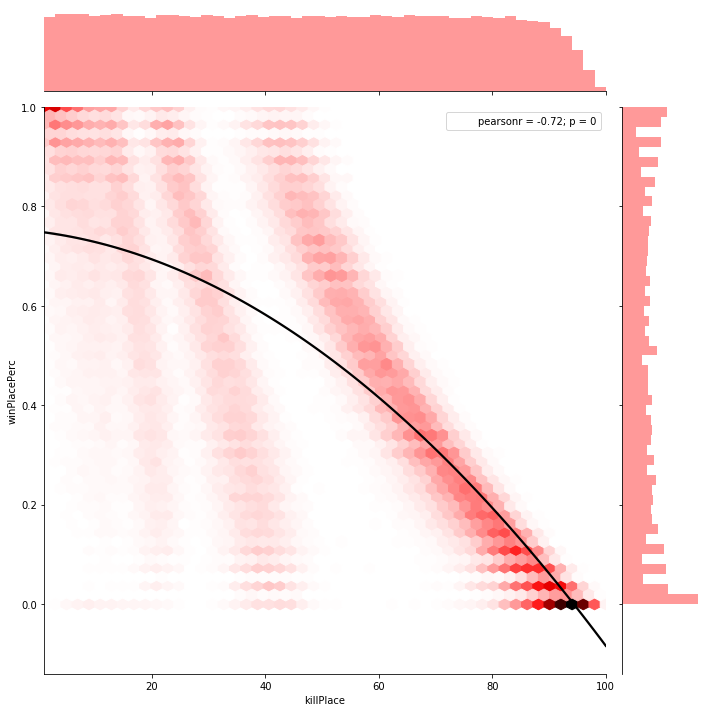

In [28]:
analysis=load_data()



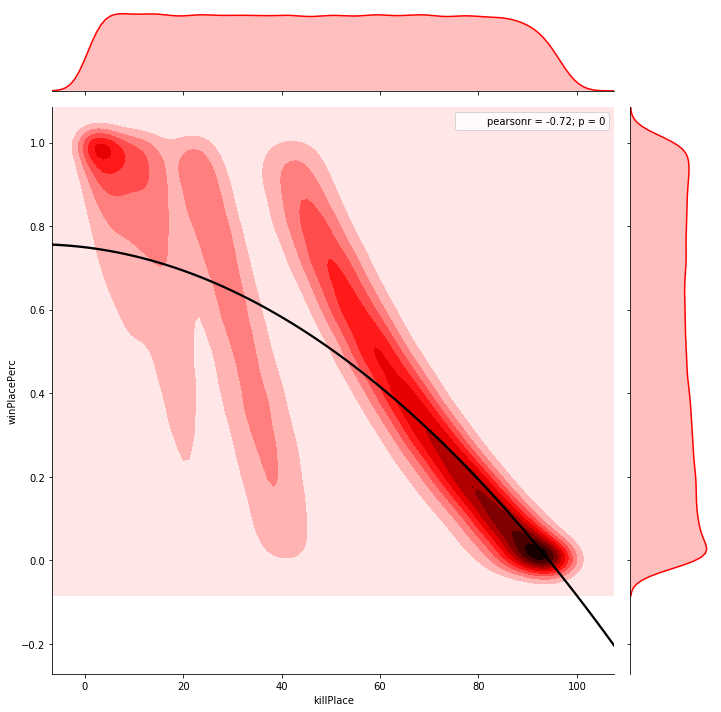

In [29]:
sns.jointplot(
    x="killPlace", 
    y="winPlacePerc", 
    data=analysis, 
    height=10, 
    ratio=6, 
    color='r',
    kind='kde',
    stat_func=pearsonr).plot_joint(sns.regplot, order=2, scatter=False, color='black')

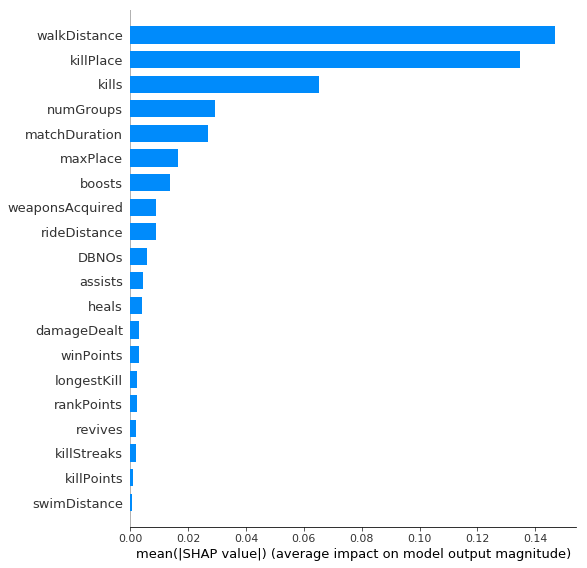

In [31]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val[fit_cols])
shap.summary_plot(shap_values, val[fit_cols], plot_type='bar')

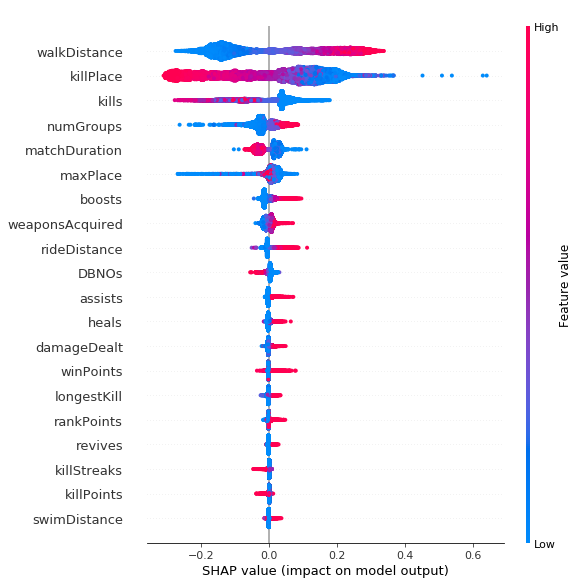

In [32]:
shap.summary_plot(shap_values, val[fit_cols], feature_names=fit_cols)

In [ ]:
 d